<a href="https://www.kaggle.com/code/kpkent/linear-model-of-proteins-only-parkinsons?scriptVersionId=122556453" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import time

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Load the Data

In [2]:
path = '/kaggle/input/amp-parkinsons-disease-progression-prediction/'
train_clinical_data = pd.read_csv(path + 'train_clinical_data.csv')
train_proteins = pd.read_csv(path + 'train_proteins.csv')
test = pd.read_csv(path + 'example_test_files/test.csv')
test_proteins = pd.read_csv(path + 'example_test_files/test_proteins.csv')

# Defining initial test metrics
metrics = ['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']

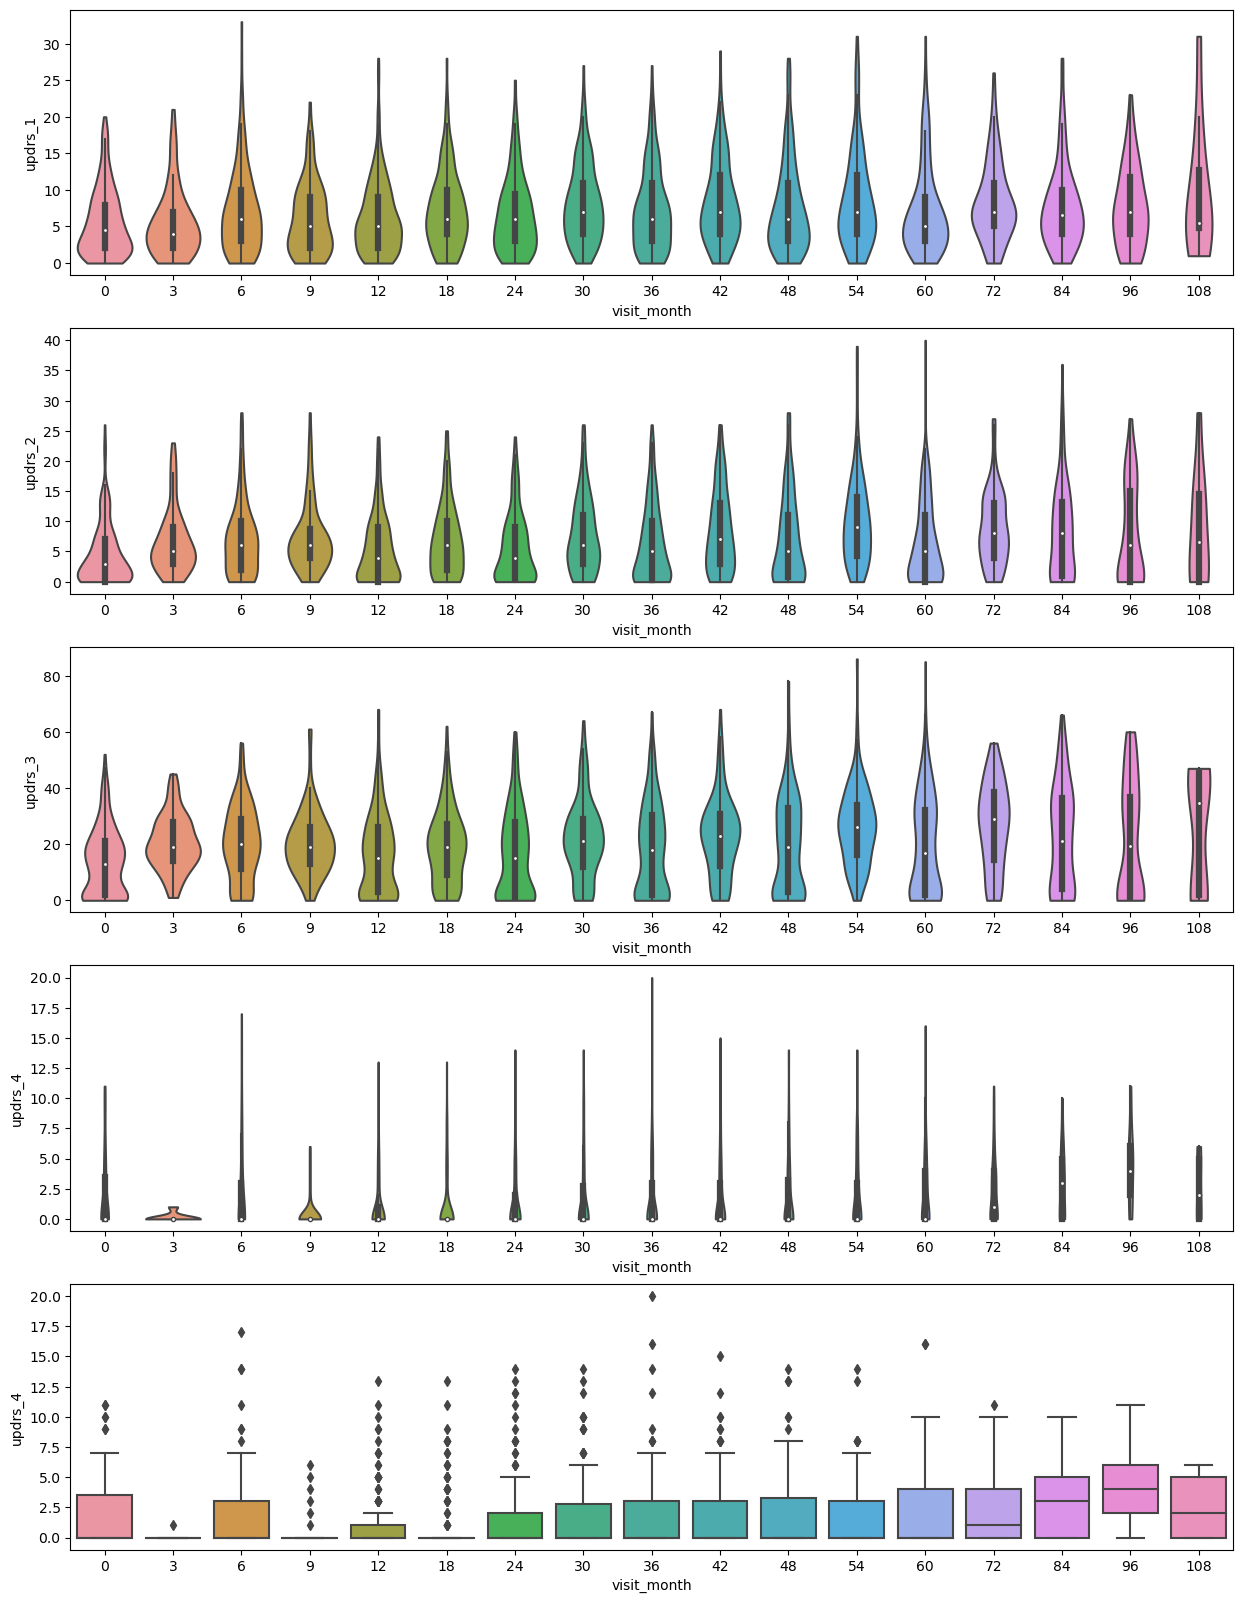

In [3]:
metrics = ['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']
plt.figure(figsize = (15,20))

for idx, met in enumerate(metrics):
    ax = plt.subplot(5,1,idx+1)
    sns.violinplot(data = train_clinical_data, y = met, x = 'visit_month', cut = 0)
    if idx == 3:
        ax = plt.subplot(5,1,idx+2)
        sns.boxplot(data = train_clinical_data, y = met, x = 'visit_month') 

# Preparing the Training Data for Model Training

<b> What We Need to Predict

Submissions are evaluated on SMAPE between forecasts and actual values. We define SMAPE = 0 when the actual and predicted values are both 0.

For each patient visit where a protein/peptide sample was taken you will need to estimate both their UPDRS scores for that visit and predict their scores for any potential visits 6, 12, and 24 months later. Predictions for any visits that didn't ultimately take place are ignored.

You must submit to this competition using the provided python time-series API, which ensures that models do not peek forward in time. To use the API, follow this template in Kaggle Notebooks:Submissions are evaluated on SMAPE between forecasts and actual values. We define SMAPE = 0 when the actual and predicted values are both 0.

For each patient visit where a protein/peptide sample was taken you will need to estimate both their UPDRS scores for that visit and predict their scores for any potential visits 6, 12, and 24 months later. Predictions for any visits that didn't ultimately take place are ignored.

You must submit to this competition using the provided python time-series API, which ensures that models do not peek forward in time. To use the API, follow this template in Kaggle Notebooks:

    import amp_pd_peptide
    env = amp_pd_peptide.make_env()   # initialize the environment
    iter_test = env.iter_test()    # an iterator which loops over the test files

    for (test, test_peptides, test_proteins, sample_submission) in iter_test:
        sample_prediction_df['rating'] = np.arange(len(sample_prediction))  # make your predictions here
        env.predict(sample_prediction_df)   # register your predictions

In [4]:
# Since the test data will have unique proteins we need to have the list of proteins for making the dataframe with the test data

def proteindata_prep(protein_df):
    
    prot_df = protein_df.pivot(index = 'visit_id', columns = 'UniProt')['NPX']
    proteins = prot_df.columns.values
    
    return prot_df, proteins


In [5]:
start = time.time()
prot_df, proteins = proteindata_prep(train_proteins)
print('Protein Manipulation Time:',time.time() - start)

Protein Manipulation Time: 0.14137744903564453


In [6]:
# Now lets merge all of the datasets together

def XyData_df(prot_df, test):
    
    test = test.set_index(test.visit_id)
    test = test.join(prot_df)
    
    return test

In [7]:
# Dump all of the peptide and protein data into a dataframe

AllTrain_df = XyData_df(prot_df, train_clinical_data)


In [8]:
# define numpy matrix for catching data

future_metrics = np.zeros((AllTrain_df.shape[0],12))

for idx,visit_id in enumerate(AllTrain_df.index):
    visit_month = AllTrain_df.loc[visit_id, 'visit_month']
    patient_id = AllTrain_df.loc[visit_id, 'patient_id']
    for idx2, month in enumerate([6,12,24]):
        #print((str(patient_id) + '_' + str(visit_month+month)))
        try:
            future_metrics[idx,(idx2*4):(idx2*4+4)] = AllTrain_df.loc[str(patient_id) + '_' + str(visit_month+month),metrics]
        except:
            future_metrics[idx,idx2*4:idx2+4] = np.nan
            


In [9]:
# set up column labels
new_cols = []
for month in [6,12,24]:
    for metric in metrics:
        new_cols.append(metric + '_' + str(month) + 'mo')

In [10]:
AllTrain_df.loc[:,new_cols] = future_metrics

In [11]:
# Add new columns to the metrics to be predicted

metrics = metrics + new_cols

# Evaluate Dimensionality Reduction Techniques (just scaling for now)

Adding this a placeholder for PCA and PLS evaluation.  For now this dataset has a natural dimensional reduction in place with the protein data.  Will try modeling with both the protein data and protein + peptide data.

In [12]:
# Simple pre-processing at the moment.

scaler = StandardScaler()

# Only the proteins that were identified from the peptides
# Filling NaN with zero because I assume that means not detected
prot_col = ['visit_month'] + proteins.tolist()
X_prot = scaler.fit_transform(AllTrain_df.loc[:,['visit_month'] + proteins.tolist()].fillna(0)) #adding in the visit month as well

# The metrics variable contains the names of each of these columns
# This does contain NaN values and will likely filter those out when fitting
y = AllTrain_df.loc[:,metrics]

# Fitting the Data

In [13]:
results_df = pd.DataFrame()
for idx, met in enumerate(metrics):
    LM = LinearRegression()
    keep = ~y.loc[:,met].isna() #dropping all values with NaN in metric
    LM.fit(X_prot[keep,:],y.loc[keep,met])
    results_df.loc[idx,'fullmodel'] = LM

In [14]:
def test_prep(test, test_proteins, proteins, scaler, results_df):
# TODO: reorder all columns in order of incoming proteins and peptides lists - add missing columns for proteins and peptides not observed in test set
    
    prot_df = test_proteins.pivot(index = 'visit_id', columns = 'UniProt')['NPX']
    prots = set(prot_df.columns).intersection(proteins)
    miss_prots = set(proteins).difference(prot_df.columns)
    prot_df = prot_df.loc[:,prots] # drop proteins not in test set
    prot_df.loc[:,miss_prots] = np.nan # add nan for missing columns
    prot_df.reindex(columns = proteins)  # Make sure columns are in same order as training set
        
    test = test.set_index(test.visit_id)
    test = test.join(prot_df)
    
    X_prot = scaler.fit_transform(test.loc[:,['visit_month'] + list(set(prot_df.columns).intersection(proteins))].fillna(0)) #adding in the visit month as well
    
    y_hat = []
    label = []
    metrics = ['updrs_1','updrs_2','updrs_3','updrs_4','updrs_1_6mo','updrs_2_6mo','updrs_3_6mo','updrs_4_6mo','updrs_1_12mo',
         'updrs_2_12mo','updrs_3_12mo','updrs_4_12mo','updrs_1_24mo','updrs_2_24mo','updrs_3_24mo','updrs_4_24mo']
    for idx2, model in enumerate(results_df.fullmodel):
        tmp = model.predict(X_prot)
        for idx,value in enumerate(tmp):
            met = metrics[idx2].split('_')
            if len(met) == 2:
                label.append(test.index[idx] + '_' + met[0] + '_' + met[1] + '_' + 'plus_0_months')
            elif met[2] == '6mo':
                label.append(test.index[idx] + '_' + met[0] + '_' + met[1] + '_' + 'plus_6_months')
            elif met[2] == '12mo':
                label.append(test.index[idx] + '_' + met[0] + '_' + met[1] + '_' + 'plus_12_months')
            else:
                label.append(test.index[idx] + '_' + met[0] + '_' + met[1] + '_' + 'plus_24_months')
            y_hat.append(value)
    submission_df = pd.DataFrame({'prediction_id':label, 'rating': y_hat}).drop_duplicates(subset = 'prediction_id') #drop duplicates - need to look into why I'm getting these
    submission_df.loc[submission_df.loc[:,'rating'] < 0,'rating'] = 0 # set all negatives equal to 0
    return (submission_df)

In [15]:
# Test the above function
tmp = test.set_index('visit_id')
submission_df = test_prep(test, test_proteins, proteins, scaler, results_df)
print('Submission Shape:',submission_df.shape)
submission_df.head(20)

Submission Shape: (64, 2)


,prediction_id,rating
0,3342_0_updrs_1_plus_0_months,7.686509
4,3342_6_updrs_1_plus_0_months,2.990756
8,50423_0_updrs_1_plus_0_months,8.780346
12,50423_6_updrs_1_plus_0_months,8.985525
16,3342_0_updrs_2_plus_0_months,7.400126
20,3342_6_updrs_2_plus_0_months,2.991460
24,50423_0_updrs_2_plus_0_months,7.695188
28,50423_6_updrs_2_plus_0_months,8.888773
32,3342_0_updrs_3_plus_0_months,20.827572
36,3342_6_updrs_3_plus_0_months,24.931755


In [16]:
import amp_pd_peptide
env = amp_pd_peptide.make_env()   # initialize the environment
iter_test = env.iter_test()    # an iterator which loops over the test files

for (test, test_peptides, test_proteins, sample_submission) in iter_test:
    submission_df = test_prep(test, test_proteins, proteins, scaler, results_df)
    
    env.predict(submission_df)   # register your predictions

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
